<a href="https://colab.research.google.com/github/jnprogrammer/MachineLearning/blob/master/Stock_Returns_via_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [5]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [6]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
# an example of the wrong method - trying to predect the price
series = df['close'].values.reshape(-1, 1)

In [0]:
# Normalize the data
# This is just an Approx of where the true boundary is.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
### Build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1,T,1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [11]:
## trying an autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 1s 2ms/sample - loss: 0.0983 - val_loss: 0.3372
Epoch 2/80
624/624 [==============================] - 0s 264us/sample - loss: 0.0111 - val_loss: 0.0363
Epoch 3/80
624/624 [==============================] - 0s 265us/sample - loss: 0.0065 - val_loss: 0.0188
Epoch 4/80
624/624 [==============================] - 0s 286us/sample - loss: 0.0056 - val_loss: 0.0147
Epoch 5/80
624/624 [==============================] - 0s 274us/sample - loss: 0.0063 - val_loss: 0.0212
Epoch 6/80
624/624 [==============================] - 0s 266us/sample - loss: 0.0072 - val_loss: 0.0178
Epoch 7/80
624/624 [==============================] - 0s 282us/sample - loss: 0.0063 - val_loss: 0.0202
Epoch 8/80
624/624 [==============================] - 0s 259us/sample - loss: 0.0055 - val_loss: 0.0225
Epoch 9/80
624/624 [==============================] - 0s 288us/sample - loss: 0.0056 - val_loss: 0.0205
Epoch 10/80
624/624 

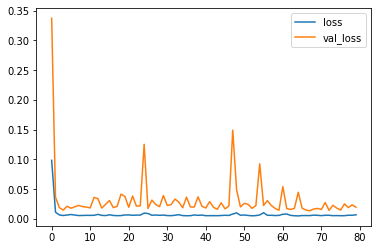

In [12]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


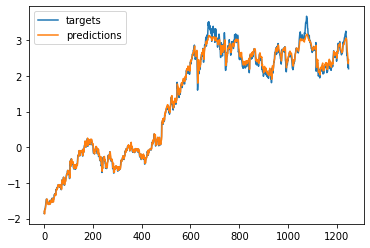

In [13]:

# one-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

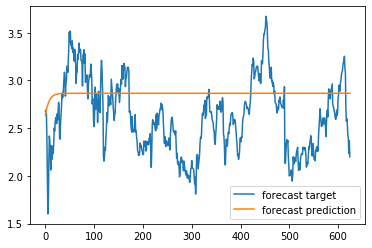

In [14]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()